In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from compute_transport import *
import torch
import torch.nn.functional as F

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(20, 10), facecolor='white')

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                         11.1.0
anyio                       NA
appnope                     0.1.2
asttokens                   NA
attr                        24.3.0
attrs                       24.3.0
babel                       2.16.0
backports                   NA
brotli                      1.0.9
certifi                     2025.01.31
charset_normalizer          3.3.2
comm                        0.2.1
compute_transport           NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.11
decorator                   5.1.1
defusedxml                  0.7.1
einops                      0.8.1
exceptiongroup              1.2.0
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
ipykernel                   6.29.5
ipywidgets                  8.1.5
jaraco                      NA
je

/Users/muqiao/miniforge3/envs/torch_env/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [3]:
df_fov = pd.read_pickle('mk_bc_fov.pkl')
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
DB3b,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB5*,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DB4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OFFx,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Generate unique mapping for index values
unique_index_values = df_fov.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_fov.index = df_fov.index.map(index_mapping)
df_fov

Mapping of annotated values to numbers:
{'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'OFFx': 10, 'DB3a': 11}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
fov_index_mapping = {'DB3b': 0, 'FMB': 1, 'IMB': 2, 'DB5*': 3, 'DB4': 4, 'DB2': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'OFFx': 10, 'DB3a': 11}
fov_bc_mapping = {value: key for key, value in fov_index_mapping.items()}
fov_bc_mapping

{0: 'DB3b',
 1: 'FMB',
 2: 'IMB',
 3: 'DB5*',
 4: 'DB4',
 5: 'DB2',
 6: 'DB1',
 7: 'BB/GB*',
 8: 'RB',
 9: 'DB6',
 10: 'OFFx',
 11: 'DB3a'}

In [6]:
# transform cell type index into a number between 100 and 200
df_fov.index = df_fov.index+101
df_fov

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.633187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_per = pd.read_pickle('mk_bc_per.pkl')
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
FMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
FMB,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
DB2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
IMB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
RB,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [8]:
# Generate unique mapping for index values
unique_index_values = df_per.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_per.index = df_per.index.map(index_mapping)
df_per

Mapping of annotated values to numbers:
{'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}


GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
1,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [9]:
per_index_mapping = {'RB': 0, 'FMB': 1, 'DB2': 2, 'IMB': 3, 'DB5*': 4, 'DB3b': 5, 'DB3a': 6, 'BB/GB*': 7, 'DB1': 8, 'DB4': 9, 'DB6': 10}
per_bc_mapping = {value: key for key, value in per_index_mapping.items()}
per_bc_mapping

{0: 'RB',
 1: 'FMB',
 2: 'DB2',
 3: 'IMB',
 4: 'DB5*',
 5: 'DB3b',
 6: 'DB3a',
 7: 'BB/GB*',
 8: 'DB1',
 9: 'DB4',
 10: 'DB6'}

In [10]:
# transform cell type index into a number above 200
df_per.index = df_per.index+201
df_per

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.594012,0.0
202,0.0,0.0,1.039235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.039235,0.0
203,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
204,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.125773,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [11]:
df = pd.concat([df_fov, df_per], axis=0)
df

GENE,ZNF692,ZNF672_p,SH3BP5L,LOC102131547,LOC107126559,ZNF496,LOC102144076,LOC102145193,ZNF124,ZNF669,...,TMLHE,MSTRG.23232,MSTRG.23233,MSTRG.23234,MSTRG.23235,MSTRG.23237,MSTRG.23238,MSTRG.23242,MSTRG.23240,MSTRG.23243
101,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
103,0.0,0.0,0.782327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
104,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.591334,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.154855,0.0
201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [12]:
# Calculate counts, means, and variances per cell type
type_counts = df.groupby(df.index).count()  # Count of cells per type
type_means = df.groupby(df.index).mean()    # Mean expression per type
type_vars = df.groupby(df.index).var()      # Variance per type

# Calculate SEM for each type
type_sems = type_vars.div(type_counts - 1).pow(0.5)  # SEM = sqrt(var/(n-1))

# Calculate overall mean expression for each gene
overall_means = df.mean()

# Calculate signal
signal = ((type_means - overall_means)**2).sum()

# Calculate noise
noise = (type_sems**2).sum()

# Calculate SNR, avoiding division by zero
snr = signal / np.maximum(noise, 1e-20)

# Sort genes by SNR in descending order
sorted_genes = snr.sort_values(ascending=False)

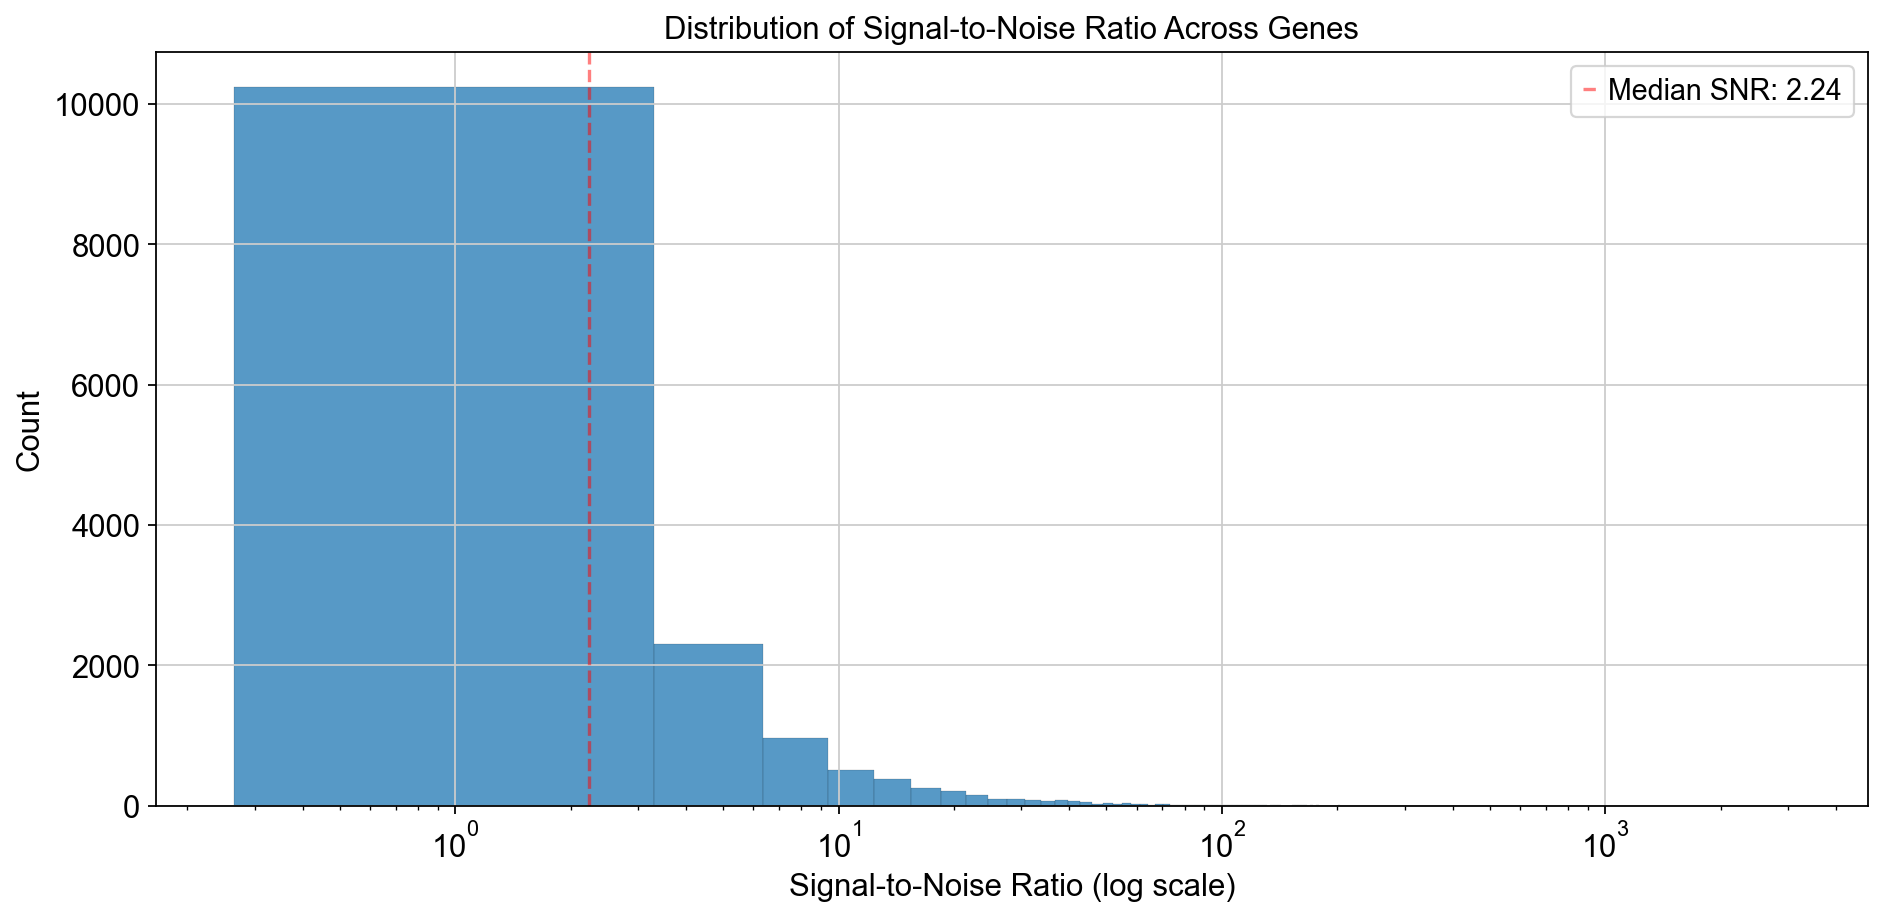


SNR Summary Statistics:
count    16161.000000
mean         9.837886
std         44.888516
min          0.264324
25%          1.331509
50%          2.238412
75%          5.470243
max       3036.074810
dtype: float64


In [13]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(data=snr, bins=1000)

# Add log scale for x-axis since SNR values often span several orders of magnitude
plt.xscale('log')

# Customize the plot
plt.title('Distribution of Signal-to-Noise Ratio Across Genes')
plt.xlabel('Signal-to-Noise Ratio (log scale)')
plt.ylabel('Count')

# Add grid for better readability
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Optional: Add vertical line at median
plt.axvline(snr.median(), color='r', linestyle='--', alpha=0.5, label=f'Median SNR: {snr.median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSNR Summary Statistics:")
print(snr.describe())

In [14]:
# Select genes with high SNR
high_snr_genes = snr[snr > 100]

# Print number of selected genes
print(f"Number of genes with great SNR: {len(high_snr_genes)}")

# Create filtered dataframe with only high SNR genes
df_filtered = df[high_snr_genes.index]

# Optional: Display first few rows and shape of filtered dataframe
print(f"\nShape of filtered dataframe: {df_filtered.shape}")
print("\nFirst few rows of filtered dataframe:")
print(df_filtered.head())

Number of genes with great SNR: 248

Shape of filtered dataframe: (30302, 248)

First few rows of filtered dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22354  MSTRG.22357  \
101            0.0  0.000000  0.000000  ...     1.525004     3.362543   
102            0.0  1.392702  0.000000  ...     0.697424     2.898434   
103            0.0  0.000000  0.000000  ...     0.782327     3.423085   
104            0.0  0.000000  0.646688  ...     1.534031     3.857981   
105            0.0  0.000000  0.000000  ...     1.790973    

In [15]:
fov_sub_df = df_filtered[df_filtered.index < 200]
per_sub_df = df_filtered[df_filtered.index >= 200]

# Print information about the split
print(f"Fovea dataframe shape: {fov_sub_df.shape}")
print(f"Peripheral dataframe shape: {per_sub_df.shape}")

# Optional: Display first few rows of each
print("\nFirst few rows of fovea dataframe:")
print(fov_sub_df.head())
print("\nFirst few rows of peripheral dataframe:")
print(per_sub_df.head())

Fovea dataframe shape: (21017, 248)
Peripheral dataframe shape: (9285, 248)

First few rows of fovea dataframe:
GENE   PROX1_p     TGFB2  KCNA3  MSTRG.1569     STMN1  RAP1GAP     RGS16  \
101   0.000000  0.000000    0.0    0.641217  0.000000      0.0  0.000000   
102   0.000000  0.000000    0.0    0.000000  0.000000      0.0  0.000000   
103   0.000000  0.000000    0.0    0.782327  1.517249      0.0  0.782327   
104   1.036175  0.000000    0.0    0.000000  1.036175      0.0  0.000000   
105   0.980239  0.605707    0.0    0.000000  0.605707      0.0  0.000000   

GENE  LOC102135846      NEK2    LPGAT1  ...  MSTRG.22354  MSTRG.22357  \
101            0.0  0.000000  0.000000  ...     1.525004     3.362543   
102            0.0  1.392702  0.000000  ...     0.697424     2.898434   
103            0.0  0.000000  0.000000  ...     0.782327     3.423085   
104            0.0  0.000000  0.646688  ...     1.534031     3.857981   
105            0.0  0.000000  0.000000  ...     1.790973     3.712

In [16]:
# transform the index back to cell type names
per_sub_df.index = per_sub_df.index - 201
per_sub_df.index = per_sub_df.index.map(per_bc_mapping)
per_sub_df

GENE,PROX1_p,TGFB2,KCNA3,MSTRG.1569,STMN1,RAP1GAP,RGS16,LOC102135846,NEK2,LPGAT1,...,MSTRG.22354,MSTRG.22357,MSTRG.22359,MSTRG.22360,MSTRG.22363,MSTRG.22513,TMSB4X,PCDH11X,LOC107128460,ANOS1
RB,1.143564,0.0,0.0,0.727049,0.727049,1.300849,0.000000,0.0,0.0,1.663142,...,2.925199,0.956837,2.458704,1.143564,3.154797,0.000000,1.663142,0.0,0.000000,1.143564
FMB,0.000000,0.0,0.0,0.000000,0.594012,0.000000,0.000000,0.0,0.0,0.000000,...,2.013558,0.000000,1.233644,0.000000,2.116395,0.000000,0.594012,0.0,0.000000,0.000000
FMB,0.000000,0.0,0.0,0.000000,1.537750,0.000000,0.000000,0.0,0.0,1.537750,...,2.117244,0.000000,1.537750,1.039235,3.049159,0.000000,0.000000,0.0,0.000000,0.000000
DB2,0.000000,0.0,0.0,0.885618,1.662684,0.000000,0.000000,0.0,0.0,0.000000,...,2.971351,0.537803,2.517362,0.885618,3.107597,0.000000,2.769901,0.0,0.000000,0.000000
IMB,1.125773,0.0,0.0,1.125773,0.000000,0.000000,1.125773,0.0,0.0,1.125773,...,2.233278,0.000000,2.233278,1.125773,2.434753,0.000000,1.125773,0.0,1.125773,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB,1.229404,0.0,0.0,0.591334,0.591334,0.000000,1.441158,0.0,0.0,0.000000,...,0.000000,3.915820,2.440881,0.591334,1.229404,0.000000,0.591334,0.0,0.000000,0.591334
RB,0.000000,0.0,0.0,0.742880,0.000000,0.000000,1.164388,0.0,0.0,0.000000,...,0.000000,4.084379,2.654915,0.000000,1.687866,0.000000,1.873325,0.0,0.000000,0.000000
RB,1.154855,0.0,0.0,0.895697,0.544949,0.000000,1.154855,0.0,0.0,0.895697,...,0.000000,3.811004,2.271533,0.000000,1.916359,1.154855,0.895697,0.0,0.895697,0.000000
RB,0.555288,0.0,0.0,0.910226,0.910226,0.000000,1.171654,0.0,0.0,0.555288,...,0.555288,3.897087,2.293474,0.555288,1.378708,0.910226,1.171654,0.0,0.555288,0.555288


In [17]:
# transform the index back to cell type names
fov_sub_df.index = fov_sub_df.index - 101
fov_sub_df.index = fov_sub_df.index.map(fov_bc_mapping)
fov_sub_df

GENE,PROX1_p,TGFB2,KCNA3,MSTRG.1569,STMN1,RAP1GAP,RGS16,LOC102135846,NEK2,LPGAT1,...,MSTRG.22354,MSTRG.22357,MSTRG.22359,MSTRG.22360,MSTRG.22363,MSTRG.22513,TMSB4X,PCDH11X,LOC107128460,ANOS1
DB3b,0.000000,0.000000,0.0,0.641217,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.525004,3.362543,0.641217,3.033673,0.000000,0.0,0.641217,0.0,0.000000,0.000000
FMB,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.392702,0.000000,...,0.697424,2.898434,0.697424,1.392702,1.104310,0.0,0.697424,0.0,0.000000,0.000000
IMB,0.000000,0.000000,0.0,0.782327,1.517249,0.000000,0.782327,0.0,0.000000,0.000000,...,0.782327,3.423085,0.782327,2.457792,0.782327,0.0,1.748542,0.0,0.000000,0.000000
DB5*,1.036175,0.000000,0.0,0.000000,1.036175,0.000000,0.000000,0.0,0.000000,0.646688,...,1.534031,3.857981,0.000000,2.954085,0.646688,0.0,1.864893,0.0,0.000000,0.646688
DB4,0.980239,0.605707,0.0,0.000000,0.605707,0.000000,0.000000,0.0,0.000000,0.000000,...,1.790973,3.712651,0.980239,3.043624,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB4,0.000000,0.000000,0.0,0.000000,1.489646,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,1.489646,0.999809,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
DB4,0.000000,0.000000,0.0,0.633187,1.840808,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,3.100385,1.511697,0.000000,0.000000,0.0,1.294950,0.0,0.000000,0.000000
OFFx,0.741789,0.000000,0.0,1.162956,0.741789,0.741789,0.000000,0.0,0.000000,0.000000,...,0.000000,2.861934,2.027902,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
IMB,0.000000,0.000000,0.0,1.309678,0.000000,0.000000,0.855475,0.0,0.000000,0.000000,...,0.855475,3.426046,2.049298,0.000000,1.309678,0.0,1.857853,0.0,0.000000,0.000000


In [18]:
# Calculate mean expression per cell type for both
fov_type_means = fov_sub_df.groupby(fov_sub_df.index).mean()
per_type_means = per_sub_df.groupby(per_sub_df.index).mean()

# Convert to torch tensors
fov_tensor = torch.tensor(fov_type_means.values, dtype=torch.float32)
per_tensor = torch.tensor(per_type_means.values, dtype=torch.float32)

# Normalize the vectors
fov_norm = F.normalize(fov_tensor, dim=1)
per_norm = F.normalize(per_tensor, dim=1)

# Compute cosine similarity (1 - cosine distance)
distance_matrix = pd.DataFrame(
    1- torch.mm(fov_norm, per_norm.t()).numpy(),
    index=fov_type_means.index,
    columns=per_type_means.index
)

In [19]:
# for plotting in the same order as that in Peng, et al. (2019)
desired_order2 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

desired_order1 = [
    "FMB",    # FMB (top)
    "DB1",    # DB1
    "OFFx",   # OFFx
    "DB2",    # DB2
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "IMB",    # IMB
    "DB4",    # DB4
    "BB/GB*", # BB/GB*
    "DB6",    # DB6
    "DB5*",   # DB5*
    "RB"      # RB (bottom)
]

In [20]:
from itertools import product
from typing import Union, List, Dict, Tuple
import time

def run_parameter_sweep(
    distance_matrix: Union[pd.DataFrame, torch.Tensor],
    alpha_values: List[float] = [0.01, 0.1, 1.0, 10.0],
    mesh_lr_values: List[float] = [0.1, 0.5, 1.0, 5.0],
    mesh_iter_values: List[int] = [1, 2, 4, 8],
    n_sh_iters: int = 5,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Perform parameter sweep for optimal transport hyperparameters.
    
    Args:
        distance_matrix: Distance/cost matrix
        alpha_values: List of regularization parameter values to test
        mesh_lr_values: List of MESH learning rate values to test
        mesh_iter_values: List of MESH iteration counts to test
        n_sh_iters: Number of Sinkhorn iterations
        verbose: Whether to show progress bar
        
    Returns:
        DataFrame with parameter combinations and their corresponding losses
    """
    # Prepare to store results
    results = []
    
    # Create parameter combinations
    combinations = list(product(alpha_values, mesh_lr_values, mesh_iter_values))
    total_combinations = len(combinations)
    
    if verbose:
        print(f"Starting parameter sweep with {total_combinations} combinations...")
        start_time = time.time()
    
    # Process each combination
    for i, (alpha, mesh_lr, mesh_iters) in enumerate(combinations):
        # Compute sparse transport matrix with current parameters
        transport_matrix = compute_sparse_transport(
            distance_matrix=distance_matrix,
            mesh_lr=mesh_lr,
            n_mesh_iters=mesh_iters,
            temperature=alpha,
            n_sh_iters=n_sh_iters
        )
        
        # Calculate loss
        loss = compute_transport_loss(
            transport_matrix=transport_matrix,
            distance_matrix=distance_matrix,
            temperature=alpha
        )
        
        # Calculate sparsity
        if isinstance(transport_matrix, pd.DataFrame):
            sparsity = (transport_matrix.values < 0.001).sum() / transport_matrix.size
        else:
            sparsity = (transport_matrix < 0.001).sum().item() / transport_matrix.numel()
            
        # Store results
        results.append({
            'alpha': alpha,
            'mesh_lr': mesh_lr,
            'mesh_iters': mesh_iters,
            'loss': loss.item() if torch.is_tensor(loss) else loss,
            'sparsity': float(sparsity)
        })
        
        # Report progress periodically
        if verbose and (i+1) % max(1, total_combinations//20) == 0:
            elapsed = time.time() - start_time
            progress = (i+1) / total_combinations
            est_total = elapsed / progress if progress > 0 else 0
            est_remaining = est_total - elapsed
            
            print(f"Progress: {i+1}/{total_combinations} combinations ({progress:.1%}), "
                  f"Est. time remaining: {est_remaining:.1f}s")
    
    if verbose:
        total_time = time.time() - start_time
        print(f"Parameter sweep completed in {total_time:.1f} seconds!")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def visualize_parameter_sweep(results_df: pd.DataFrame, output_dir: str = None) -> None:
    """
    Visualize parameter sweep results.
    
    Args:
        results_df: DataFrame with parameter sweep results
        output_dir: Directory to save plots (if None, plots are only displayed)
    """
    # Create figure for loss heatmaps
    fig, axes = plt.subplots(len(set(results_df['mesh_iters'])), 1, 
                            figsize=(10, 4 * len(set(results_df['mesh_iters']))),
                            squeeze=False)
    
    # Plot loss heatmaps for each mesh_iters value
    for i, mesh_iters in enumerate(sorted(results_df['mesh_iters'].unique())):
        subset = results_df[results_df['mesh_iters'] == mesh_iters]
        pivot = subset.pivot_table(index='alpha', columns='mesh_lr', values='loss')
        
        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues_r", ax=axes[i, 0])
        axes[i, 0].set_title(f'Loss: mesh_iters = {mesh_iters}')
        axes[i, 0].set_xlabel('MESH Learning Rate (λ)')
        axes[i, 0].set_ylabel('Regularization Parameter (α)')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(f"{output_dir}/loss_heatmaps.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create figure for sparsity heatmaps
    fig, axes = plt.subplots(len(set(results_df['mesh_iters'])), 1, 
                            figsize=(10, 4 * len(set(results_df['mesh_iters']))),
                            squeeze=False)
    
    # Plot sparsity heatmaps for each mesh_iters value
    for i, mesh_iters in enumerate(sorted(results_df['mesh_iters'].unique())):
        subset = results_df[results_df['mesh_iters'] == mesh_iters]
        pivot = subset.pivot_table(index='alpha', columns='mesh_lr', values='sparsity')
        
        sns.heatmap(pivot, annot=True, fmt=".2%", cmap="Reds", ax=axes[i, 0])
        axes[i, 0].set_title(f'Sparsity: mesh_iters = {mesh_iters}')
        axes[i, 0].set_xlabel('MESH Learning Rate (λ)')
        axes[i, 0].set_ylabel('Regularization Parameter (α)')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(f"{output_dir}/sparsity_heatmaps.png", dpi=300, bbox_inches='tight')
    plt.show()
    

    # Plot loss vs. sparsity with different shapes, sizes, and colors
    plt.figure(figsize=(12, 8))
    
    # Define markers for different alpha values
    markers = {0.01: 'o', 0.1: 's', 1.0: '^', 10.0: 'D', 100.0: 'P'}
    
    # Get unique values for creating a proper legend
    unique_alphas = sorted(results_df['alpha'].unique())
    unique_mesh_lrs = sorted(results_df['mesh_lr'].unique())
    unique_mesh_iters = sorted(results_df['mesh_iters'].unique())
    
    # Create a color map for T values (mesh_iters)
    cmap = plt.cm.Dark2
    norm = plt.Normalize(min(unique_mesh_iters), max(unique_mesh_iters))
    
    # Plot each point
    legend_elements = []
    
    # First add scatter plots for each combination
    for alpha in unique_alphas:
        for mesh_iters in unique_mesh_iters:
            subset = results_df[(results_df['mesh_iters'] == mesh_iters) & 
                               (results_df['alpha'] == alpha)]
            
            if not subset.empty:
                marker = markers.get(alpha, 'o')
                color = cmap(norm(mesh_iters))
                
                plt.scatter(
                    subset['sparsity'], 
                    subset['loss'],
                    c=[color], 
                    s=subset['mesh_lr']*20, 
                    marker=marker,
                    alpha=0.7,
                    label=f"T={mesh_iters}, α={alpha}"
                )
    
    # Add shape legend (alpha values)
    for alpha in unique_alphas:
        marker = markers.get(alpha, 'o')
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='black', 
                               label=f'α={alpha}', markersize=10, linestyle='None'))
    
    # Add color legend (T values)
    for mesh_iters in unique_mesh_iters:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color=cmap(norm(mesh_iters)), 
                               label=f'T={mesh_iters}', markersize=10, linestyle='None'))
    
    # Add size legend (lambda values)
    for lr in unique_mesh_lrs:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='gray', 
                               label=f'λ={lr}', markersize=np.sqrt(lr*20/np.pi), linestyle='None'))
    
    plt.xlabel('Sparsity')
    plt.ylabel('Transport Loss')
    plt.title('Loss vs. Sparsity Trade-off')
    
    # Add a legend outside the plot
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
               title="Parameters", fontsize='small')
    
    # Annotate important points
    for _, row in results_df.iterrows():
        if row['loss'] == results_df[results_df['sparsity'] >= 0.5]['loss'].min():
            plt.annotate(
                f"α={row['alpha']}, λ={row['mesh_lr']}, T={row['mesh_iters']}",
                (row['sparsity']*0.9, row['loss']*2.0),
                xytext=(5, 5), 
                textcoords='offset points'
            )
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(f"{output_dir}/loss_vs_sparsity.png", dpi=300, bbox_inches='tight')
    plt.show()


def find_optimal_parameters(
    results_df: pd.DataFrame, 
    sparsity_threshold: float = 0.5,
    loss_weight: float = 0.7,
    sparsity_weight: float = 0.3
) -> Dict:
    """
    Find optimal parameters based on loss and sparsity trade-off.
    
    Args:
        results_df: DataFrame with parameter sweep results
        sparsity_threshold: Minimum acceptable sparsity
        loss_weight: Weight for loss in combined scoring
        sparsity_weight: Weight for sparsity in combined scoring
        
    Returns:
        Dictionary with optimal parameters
    """
    # Filter based on sparsity threshold
    filtered_df = results_df[results_df['sparsity'] >= sparsity_threshold]
    
    if filtered_df.empty:
        print("No parameter combinations meet the sparsity threshold!")
        return None
    
    # Normalize loss and sparsity for scoring
    min_loss = filtered_df['loss'].min()
    max_loss = filtered_df['loss'].max()
    normalized_loss = (filtered_df['loss'] - min_loss) / (max_loss - min_loss) if max_loss > min_loss else 0
    
    # For sparsity, higher is better
    normalized_sparsity = filtered_df['sparsity']
    
    # Compute combined score (lower is better for loss, higher is better for sparsity)
    filtered_df['score'] = loss_weight * (1 - normalized_loss) + sparsity_weight * normalized_sparsity
    
    # Get best parameters
    best_row = filtered_df.loc[filtered_df['score'].idxmax()]
    
    return {
        'alpha': best_row['alpha'],
        'mesh_lr': best_row['mesh_lr'],
        'mesh_iters': int(best_row['mesh_iters']),
        'loss': best_row['loss'],
        'sparsity': best_row['sparsity'],
        'score': best_row['score']
    }

def run_parameter_selection(
    distance_matrix: Union[pd.DataFrame, torch.Tensor],
    output_dir: str = None,
    alpha_values: List[float] = [0.01, 0.1, 1.0, 10.0],
    mesh_lr_values: List[float] = [0.1, 0.5, 1.0, 5.0],
    mesh_iter_values: List[int] = [1, 2, 4, 8],
    sparsity_threshold: float = 0.5,
    n_sh_iters: int = 5
) -> Tuple[Dict, pd.DataFrame]:
    """
    Run full parameter selection process and return optimal parameters.
    
    Args:
        distance_matrix: Distance/cost matrix
        output_dir: Directory to save plots
        alpha_values: List of regularization parameter values to test
        mesh_lr_values: List of MESH learning rate values to test
        mesh_iter_values: List of MESH iteration counts to test
        sparsity_threshold: Minimum acceptable sparsity
        n_sh_iters: Number of Sinkhorn iterations
        
    Returns:
        Tuple of (optimal parameters dict, full results DataFrame)
    """
    # Run parameter sweep
    results_df = run_parameter_sweep(
        distance_matrix=distance_matrix,
        alpha_values=alpha_values,
        mesh_lr_values=mesh_lr_values,
        mesh_iter_values=mesh_iter_values,
        n_sh_iters=n_sh_iters
    )
    
    # Visualize results
    visualize_parameter_sweep(results_df, output_dir)
    
    # Find optimal parameters
    optimal_params = find_optimal_parameters(
        results_df=results_df,
        sparsity_threshold=sparsity_threshold
    )
    
    # Print optimal parameters
    if optimal_params:
        print("\nOptimal Parameters:")
        print(f"Regularization (α): {optimal_params['alpha']}")
        print(f"MESH Learning Rate (λ): {optimal_params['mesh_lr']}")
        print(f"MESH Iterations (T): {optimal_params['mesh_iters']}")
        print(f"Resulting Loss: {optimal_params['loss']:.4f}")
        print(f"Resulting Sparsity: {optimal_params['sparsity']:.2%}")
    
    return optimal_params, results_df

Starting parameter sweep with 64 combinations...
Progress: 3/64 combinations (4.7%), Est. time remaining: 14.5s
Progress: 6/64 combinations (9.4%), Est. time remaining: 7.1s
Progress: 9/64 combinations (14.1%), Est. time remaining: 4.6s
Progress: 12/64 combinations (18.8%), Est. time remaining: 3.3s
Progress: 15/64 combinations (23.4%), Est. time remaining: 2.5s
Progress: 18/64 combinations (28.1%), Est. time remaining: 1.9s
Progress: 21/64 combinations (32.8%), Est. time remaining: 1.6s
Progress: 24/64 combinations (37.5%), Est. time remaining: 1.3s
Progress: 27/64 combinations (42.2%), Est. time remaining: 1.1s
Progress: 30/64 combinations (46.9%), Est. time remaining: 0.9s
Progress: 33/64 combinations (51.6%), Est. time remaining: 0.7s
Progress: 36/64 combinations (56.2%), Est. time remaining: 0.6s
Progress: 39/64 combinations (60.9%), Est. time remaining: 0.5s
Progress: 42/64 combinations (65.6%), Est. time remaining: 0.4s
Progress: 45/64 combinations (70.3%), Est. time remaining: 

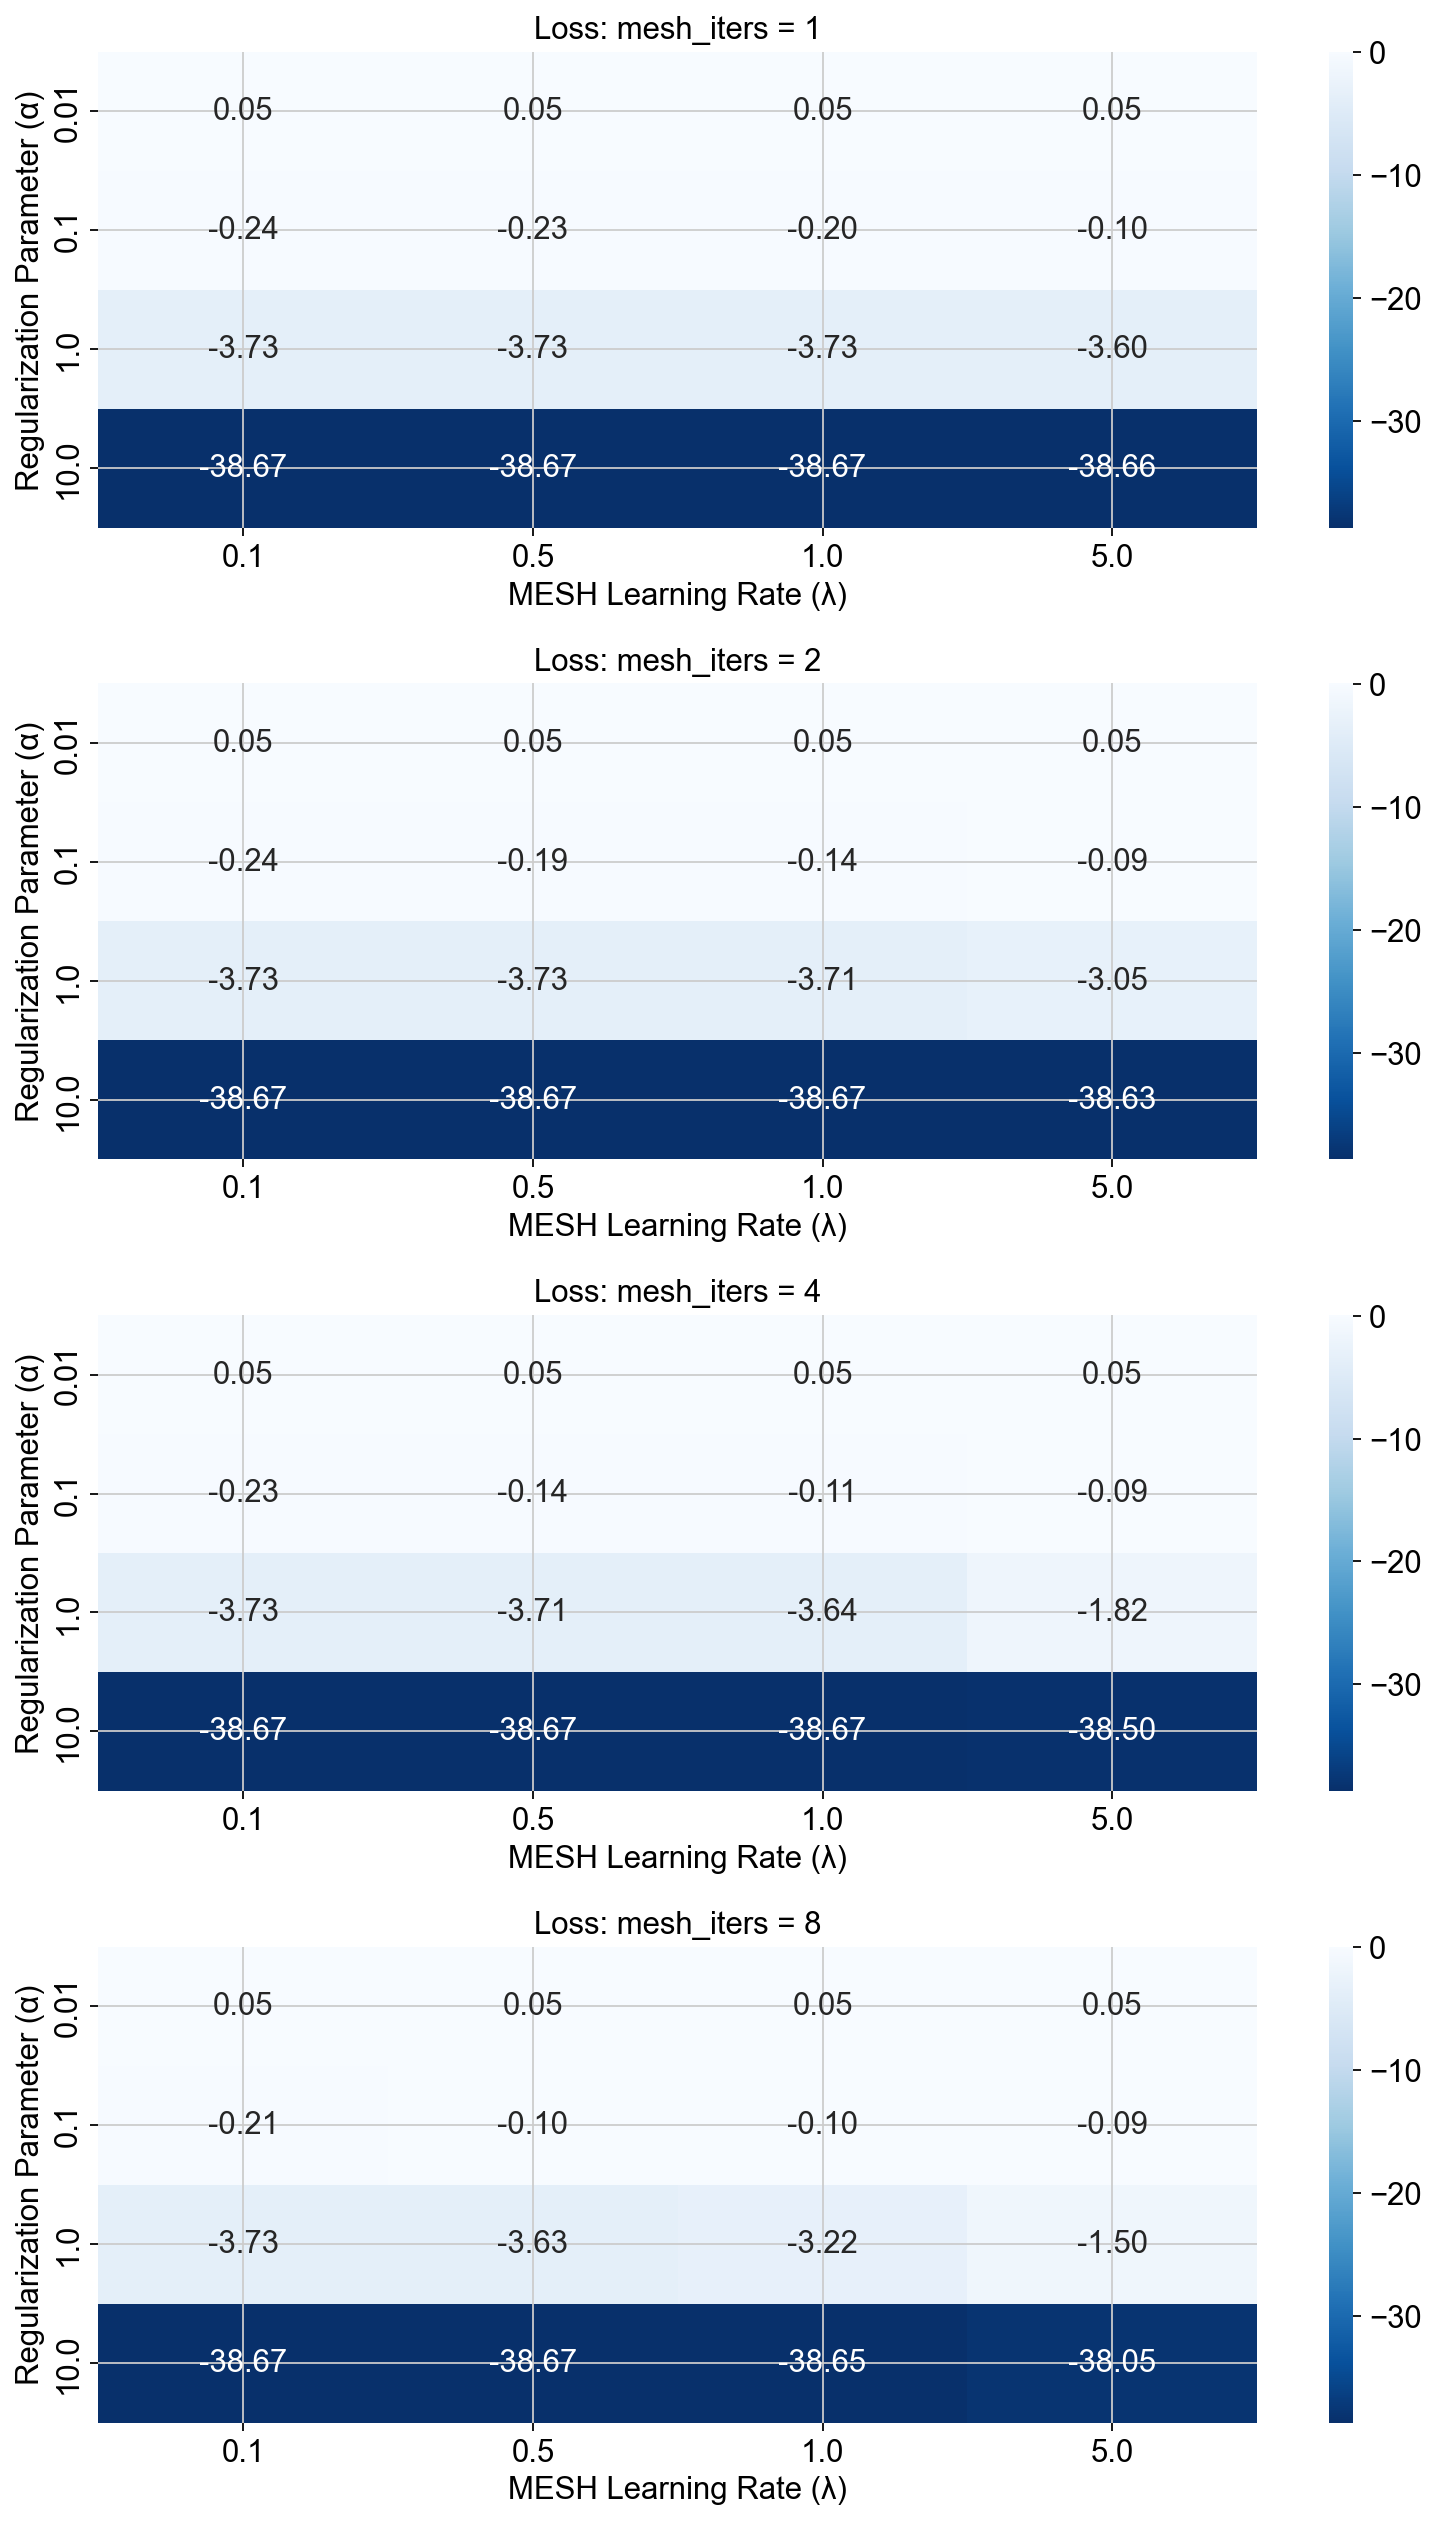

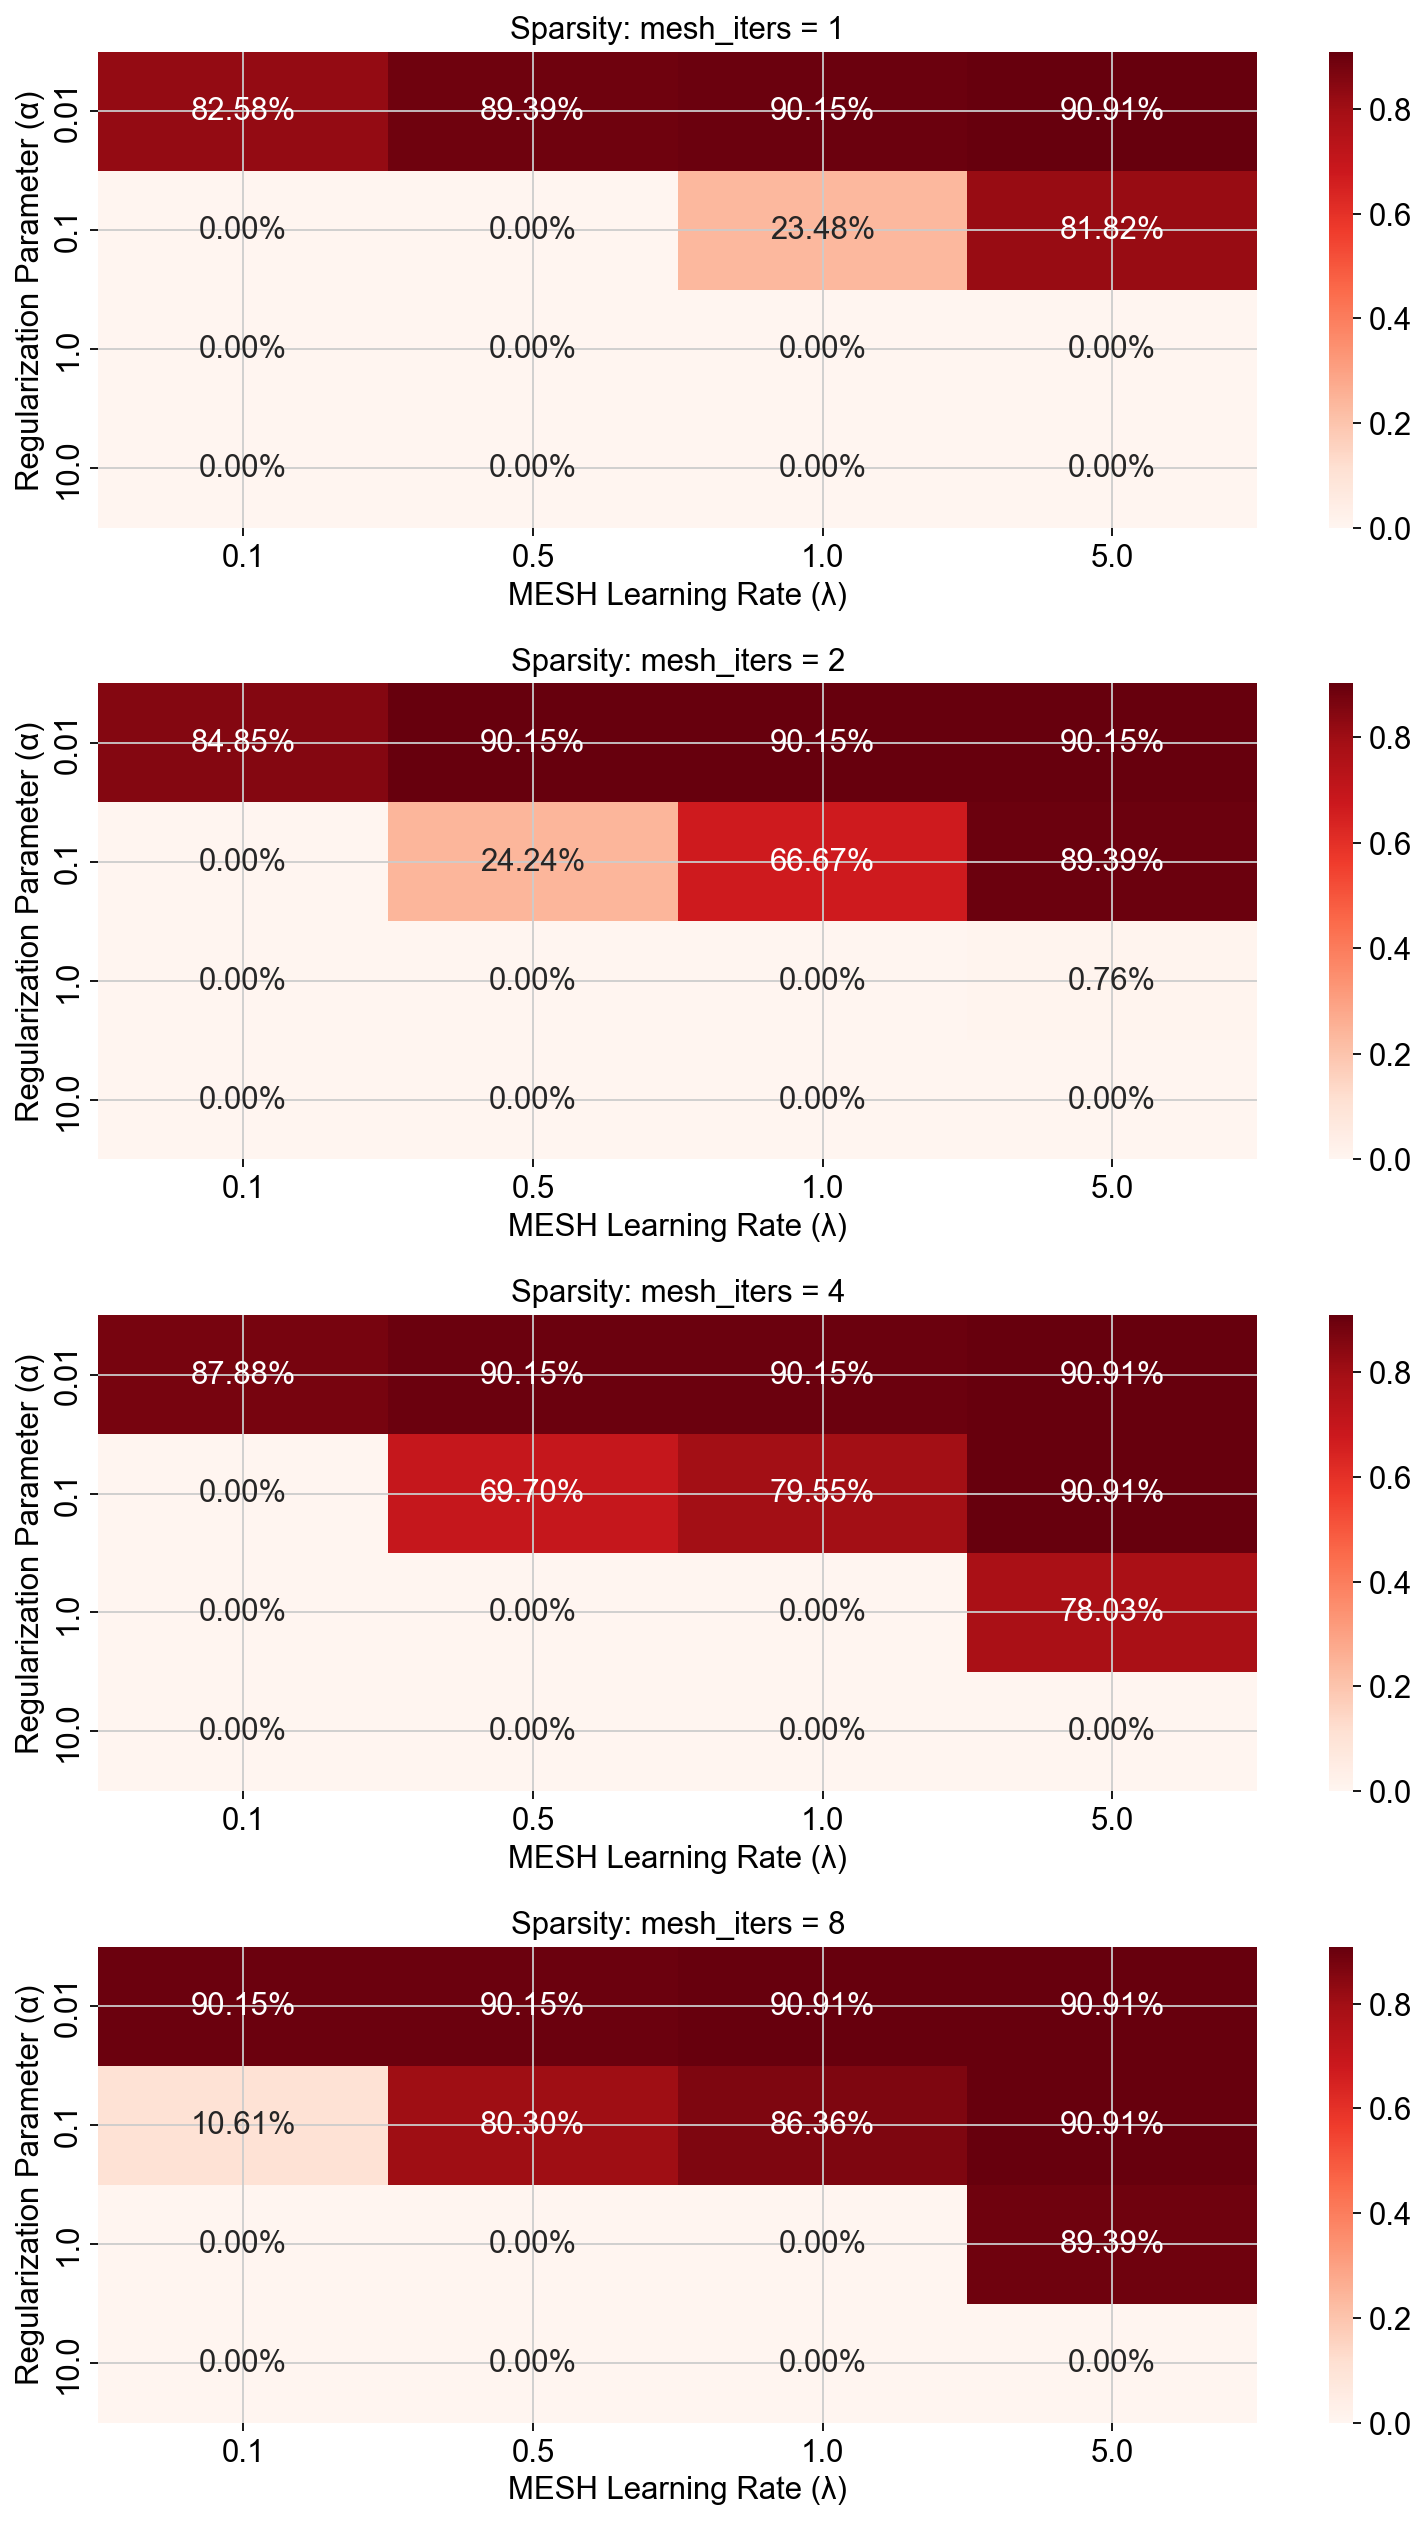

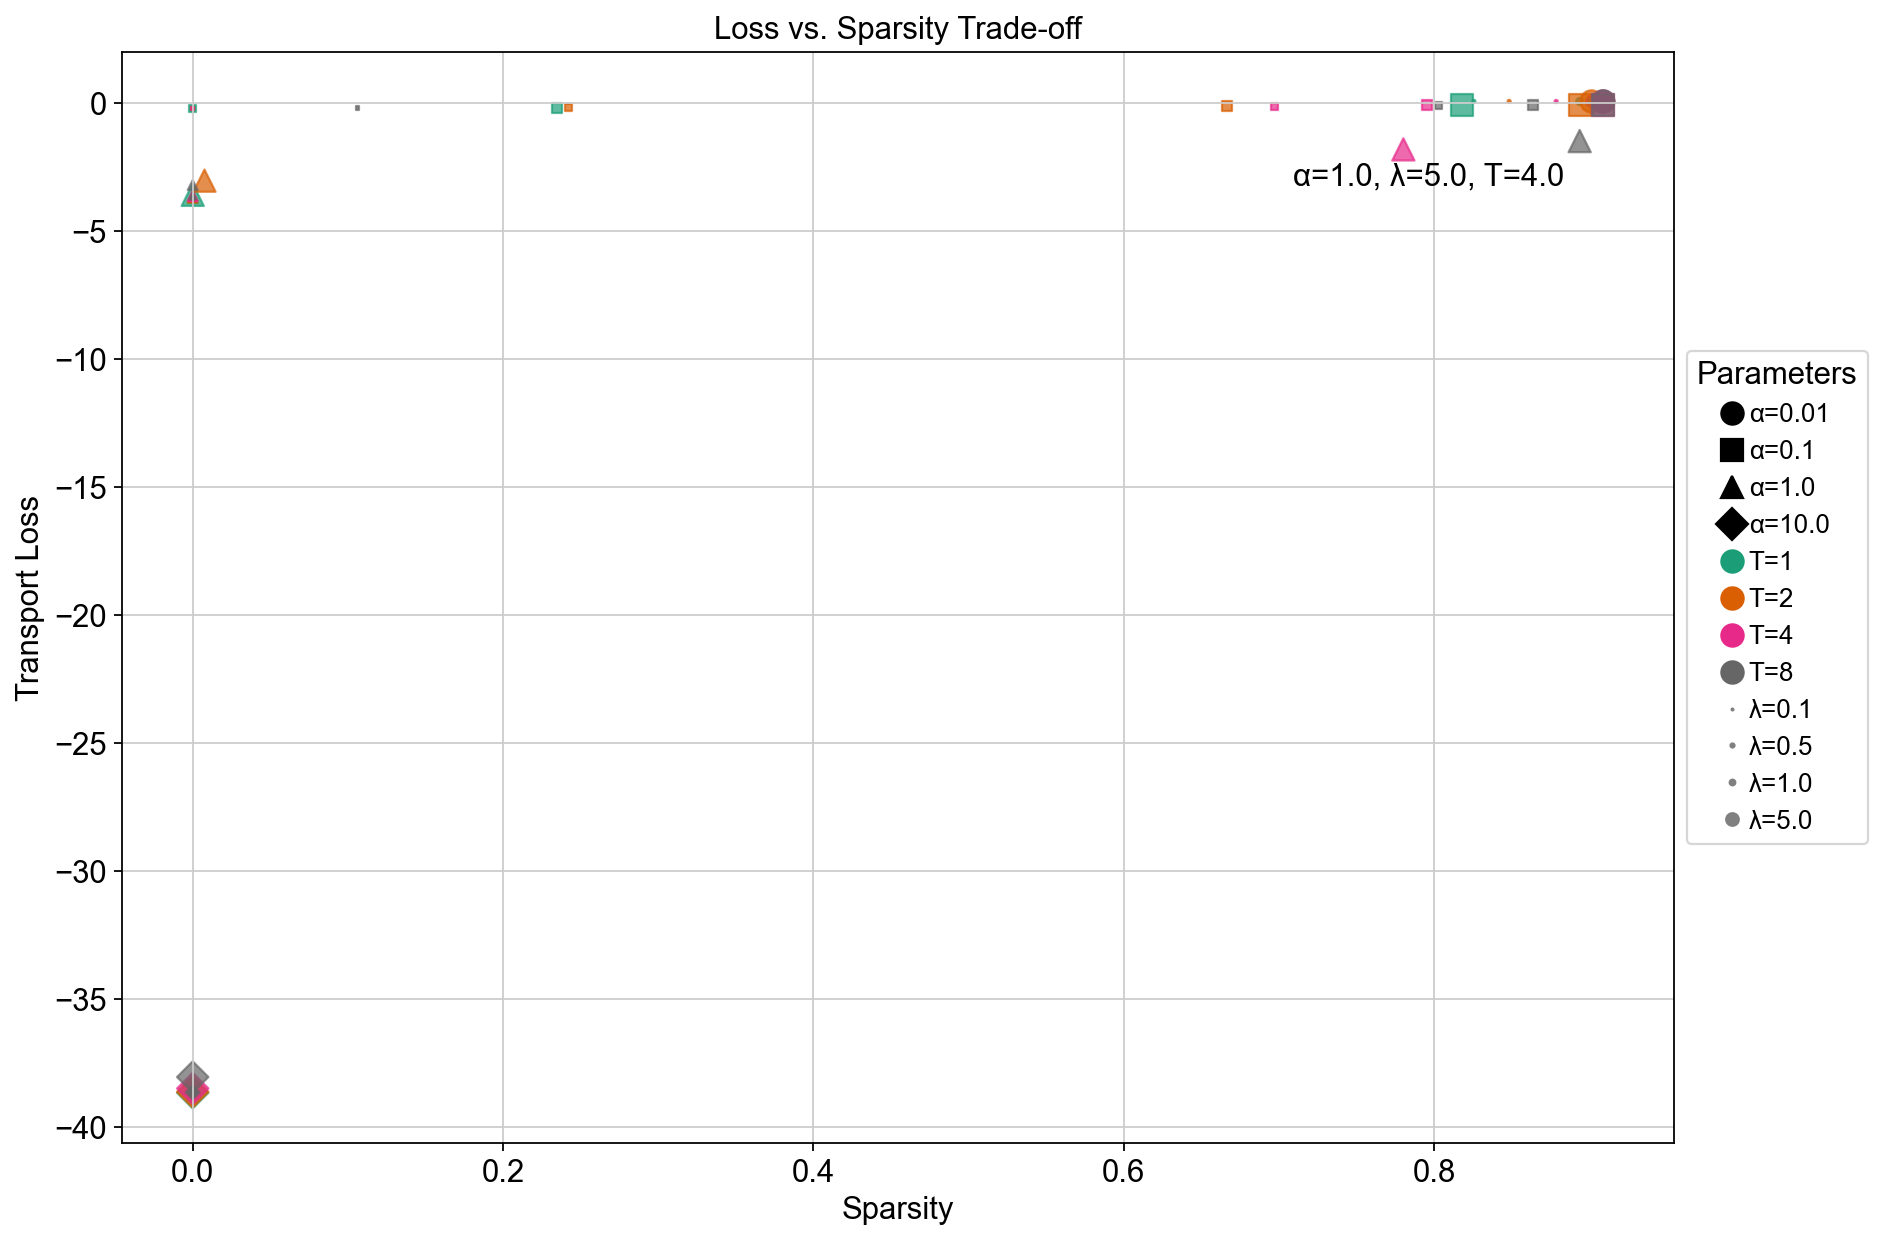


Optimal Parameters:
Regularization (α): 1.0
MESH Learning Rate (λ): 5.0
MESH Iterations (T): 4
Resulting Loss: -1.8245
Resulting Sparsity: 78.03%


/var/folders/yq/mt1zw2_j3d5g1lpzzv8vb0w40000gn/T/ipykernel_51735/1629237224.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['score'] = loss_weight * (1 - normalized_loss) + sparsity_weight * normalized_sparsity


In [21]:
# Run parameter selection
optimal_params, results = run_parameter_selection(
    output_dir="./Validation_Parameter_Plots",
    distance_matrix=distance_matrix,
    sparsity_threshold=0.5
)

final_transport = compute_sparse_transport(
    distance_matrix=distance_matrix,
    mesh_lr=optimal_params['mesh_lr'],
    n_mesh_iters=optimal_params['mesh_iters'],
    temperature=optimal_params['alpha'],
    n_sh_iters=5
)

In [22]:
final_transport = compute_sparse_transport(
    distance_matrix=distance_matrix,
    mesh_lr=0.1,
    n_mesh_iters=1,
    temperature=10,
    n_sh_iters=5
)
final_transport

,BB/GB*,DB1,DB2,DB3a,DB3b,DB4,DB5*,DB6,FMB,IMB,RB
BB/GB*,0.007651,0.007570,0.007559,0.007547,0.007553,0.007547,0.007559,0.007588,0.007573,0.007624,0.007562
DB1,0.007573,0.007684,0.007566,0.007571,0.007551,0.007526,0.007533,0.007607,0.007602,0.007566,0.007553
DB2,0.007568,0.007559,0.007655,0.007585,0.007616,0.007562,0.007557,0.007540,0.007602,0.007555,0.007534
DB3a,0.007544,0.007568,0.007587,0.007686,0.007609,0.007575,0.007547,0.007563,0.007579,0.007540,0.007537
DB3b,0.007553,0.007554,0.007623,0.007617,0.007646,0.007583,0.007557,0.007536,0.007590,0.007543,0.007532
DB4,0.007547,0.007521,0.007564,0.007579,0.007595,0.007668,0.007623,0.007538,0.007540,0.007558,0.007601
DB5*,0.007559,0.007526,0.007555,0.007545,0.007561,0.007632,0.007658,0.007551,0.007541,0.007583,0.007622
DB6,0.007582,0.007608,0.007539,0.007559,0.007531,0.007536,0.007562,0.007680,0.007563,0.007583,0.007591
FMB,0.007584,0.007609,0.007603,0.007566,0.007582,0.007540,0.007541,0.007570,0.007629,0.007566,0.007542
IMB,0.007615,0.007562,0.007554,0.007542,0.007548,0.007563,0.007583,0.007579,0.007559,0.007648,0.007579
